<a href="https://colab.research.google.com/github/dchappell2/Analytical_Mechanics/blob/main/Analytical_Mechanics/falling_object_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Falling Object Motion Analysis

This notebook reads experimental **time** (s) and **vertical position** (m) data, plots the measurements, and overlays two theoretical curves:
- **Vacuum**: Free fall with no air resistance
- **Quadratic drag**: Motion with air resistance proportional to $v^2$

Parameters: mass, diameter, air density, air viscosity, drag coefficient.

## 1. Imports and setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## 2. Load data

Data file has **two header lines** (first line is a title/comment, second is column names) and **tab-separated** columns: **time** (seconds) and **position** (meters).

To load this file run the following commands. You only need to do this once to load the data into Google:

In [ ]:
# Upload a file in Colab
from google.colab import files
uploaded = files.upload()
data_file = list(uploaded.keys())[0]


Saving falling_object_data.csv to falling_object_data.csv
Loaded 21 points
   time  position
0   0.0     10.00
1   0.1      9.95
2   0.2      9.80
3   0.3      9.56
4   0.4      9.22


Now that your data file is loaded, run the following commands to read in the column data. You should see the first few rows of your data displayed.

In [ ]:
# Two header lines: skip first, use second as column names; columns are tab-separated
df = pd.read_csv(data_file, sep='\t', skiprows=2)
# If your columns have different names, rename them:
# df = df.rename(columns={'t': 'time', 'y': 'position'})
time_data = df['time'].values
position_data = df['position'].values

print(f'Loaded {len(time_data)} points')
print(df.head())

## 3. Physical parameters

Set object and air properties. These are used for the vacuum solution and the quadratic-drag model.

In [ ]:
# Object
mass = 0.1                # kg
diameter = 0.03           # meters (e.g. 3 cm sphere)
drag_coefficient = 0.47   # dimensionless, ~0.47 for smooth sphere

# Air (at ~20°C, sea level)
air_density = 1.225       # kg/m³
air_viscosity = 1.81e-5   # Pa·s

# Gravity
g = 9.81  # m/s²

# Cross-sectional area (sphere: A = pi * d^2 / 4)
area = np.pi * (diameter / 2) ** 2

# Initial conditions from first data point (or set manually)
y0 = position_data[0]    # m
v0 = 0.0                 # m/s (or estimate from first two points)
if len(time_data) >= 2:
    v0 = (position_data[1] - position_data[0]) / (time_data[1] - time_data[0])

print(f'Initial height: {y0:.3f} m, initial velocity: {v0:.3f} m/s')
print(f'Area: {area:.6f} m²')

Initial height: 10.000 m, initial velocity: -0.500 m/s
Area: 0.000707 m²


## 4. Theoretical models

- **Vacuum**: $y(t) = y_0 + v_0 t - \frac{1}{2} g t^2$
- **Quadratic drag**: $m\frac{dv}{dt} = mg - \frac{1}{2}\rho C_d A v^2$ (downward positive), solved numerically.

In [ ]:
t_max = time_data.max()
t_eval = np.linspace(0, t_max, 200)

# --- Vacuum solution (analytic) ---
def position_vacuum(t, y0, v0, g):
    return y0 + v0 * t - 0.5 * g * t**2

y_vacuum = position_vacuum(t_eval, y0, v0, g)

# --- Quadratic drag (ODE: dv/dt = g - (rho*Cd*A/(2*m)) * v^2, dy/dt = v) ---
k = 0.5 * air_density * drag_coefficient * area / mass  # coefficient of v^2 term

def falling_drag(t, state):
    y, v = state
    # dv/dt = g - k*v^2 (downward positive); dy/dt = v
    # sign of v so drag always opposes motion
    if v >= 0:
        dv = -g - k * v**2
    else:
        dv = -g + k * v**2
    return [v, dv]

sol = solve_ivp(falling_drag, [0, t_max], [y0, v0], t_eval=t_eval, dense_output=False)
t_drag = sol.t
y_drag = sol.y[0]

## 5. Plot: position vs time

Data points with overlay of vacuum and quadratic-drag solutions.

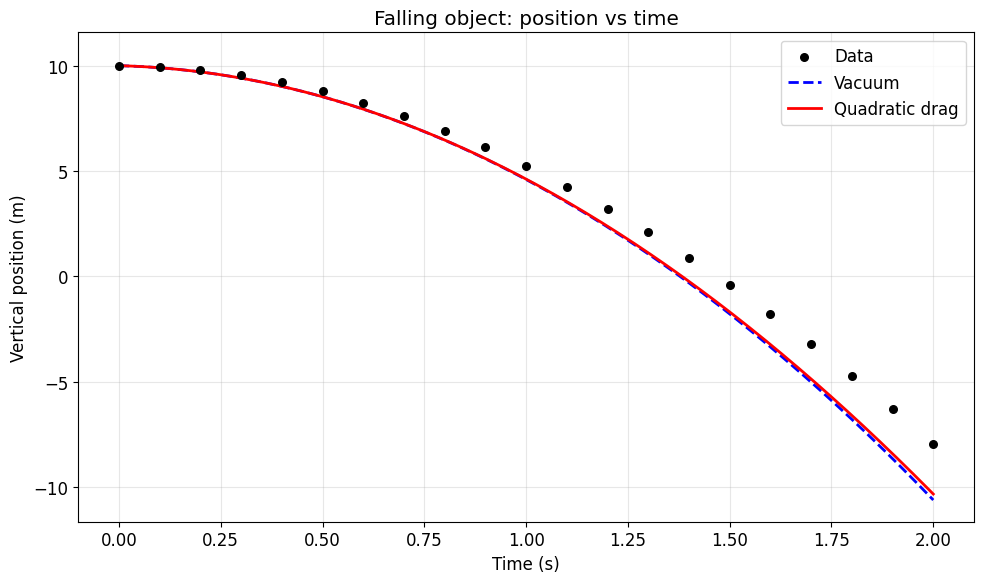

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(time_data, position_data, color='black', s=30, zorder=3, label='Data')
ax.plot(t_eval, y_vacuum, '--', color='blue', linewidth=2, label='Vacuum')
ax.plot(t_drag, y_drag, '-', color='red', linewidth=2, label='Quadratic drag')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Vertical position (m)')
ax.set_title('Falling object: position vs time')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(top=ax.get_ylim()[1] * 1.05)
plt.tight_layout()
plt.show()

## 6. (Optional) Reynolds number

Re = ρ v D / μ. For quadratic drag to be appropriate, Re is typically large. Below we estimate Re using the average speed over the fall.

In [ ]:
v_typical = np.abs(position_data[-1] - position_data[0]) / (time_data[-1] - time_data[0])
Re = air_density * v_typical * diameter / air_viscosity
print(f'Typical speed: {v_typical:.2f} m/s')
print(f'Reynolds number Re ≈ {Re:.0f}')
print('Quadratic drag is reasonable for Re >> 1 (e.g. Re > 1000).')

Typical speed: 8.98 m/s
Reynolds number Re ≈ 18233
Quadratic drag is reasonable for Re >> 1 (e.g. Re > 1000).
